# Importing packages

In [1]:
import torch
import numpy as np
import lightning as L
import shutil

import torch.nn as nn
import torch
from torchinfo import summary
from torchviz import make_dot
import lightning.pytorch as pl

import torchmetrics
from lightning.pytorch.callbacks import ModelCheckpoint, Callback
from lightning.pytorch import Trainer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../transforms/')
sys.path.append('../../TFC_Configs/')
sys.path.append('../../models/')
sys.path.append('../../data_modules/')

from config_files.TFC_Configs import *
from transforms.tfc_augmentations import *
from transforms.tfc_utils import set_seed, plot_model_metrics
from models.tfc import *
from data_modules.uci import *

In [4]:
set_seed(42)

In [5]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 22,
    'axes.linewidth': 2,
    'axes.titlesize': 24,
    'axes.edgecolor': 'black',
    'axes.labelsize': 24,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'font.family': 'Times New Roman',
    'legend.fontsize': 16,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

# Loading the Data with Dataloader

In [6]:
global_config = GlobalConfigFile() 

In [7]:
tfc_transforms = TFC_transforms(global_config,verbose=False)

uci_data_module = UCIDataModule(root_data_dir='../../data/uci/preprocessed/',
                           batch_size=32,
                           flatten=False,
                           target_column='class',
                           training_mode='TFC',
                           transform=tfc_transforms)

train_uci_dl = uci_data_module.train_dataloader()

In [8]:
loader_iter = iter(train_uci_dl)
first_batch = next(iter(train_uci_dl))

In [9]:
original_data, time_augmented_data, norm_amplitude_spectrum, norm_amplitude_spectrum_aug, target = first_batch

In [10]:
print("Original Data Shape:", original_data.shape)
print("Time Augmented Shape:", time_augmented_data.shape)
print("FFT of Original Data Shape:", norm_amplitude_spectrum.shape)
print("Frequency Augmented Shape:", norm_amplitude_spectrum_aug.shape)
print("Target Shape:", target.shape)

Original Data Shape: torch.Size([32, 6, 60])
Time Augmented Shape: torch.Size([32, 6, 60])
FFT of Original Data Shape: torch.Size([32, 6, 60])
Frequency Augmented Shape: torch.Size([32, 6, 60])
Target Shape: torch.Size([32])


# 1.0 Creating the Time and Frequency Encoders

**Overview of TF-C approach.** The model has four components: a time encoder, a frequency encoder, and two cross-space projectors that map time-based and frequency-based representations, respectively, to the same time-frequency space. Together, the four components provide a way to embed the input time series to the latent time-frequency space such that time-based embedding and frequency-based embedding are close together. 

The TF-C property is realized by promoting the alignment of time- and frequency-based representations in the latent time-frequency space, providing a vehicle for transferring the well-trained model to a target dataset not seen before. Let's see how this is done

- `In the 2022 github repository`, all 4 encoders were a 1-D convolutional neural network with 3 layers
- `In the 2023 github repository`, all 4 encoders were a Transformer networks (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html) 

We will use the 1-D convolutional encoder since this is what the original paper used, while also being less computationally demanding. We also use the same projection head as the github

## 1.1 All Encoders (Time + Freq + Crosspace)

The first term of the tfc_model is fed to the time encoder, while the second term is fed to the frequency encoder

In [11]:
backbone = TFC_Backbone(global_config, log_metrics=False).to(device)
print(summary(backbone, input_size=[(32, 6, 60), (32, 6, 60)]))

Layer (type:depth-idx)                   Output Shape              Param #
TFC_Backbone                             [32, 18]                  --
├─Sequential: 1-1                        [32, 32, 5]               --
│    └─Conv1d: 2-1                       [32, 32, 8]               1,536
│    └─BatchNorm1d: 2-2                  [32, 32, 8]               64
│    └─ReLU: 2-3                         [32, 32, 8]               --
│    └─MaxPool1d: 2-4                    [32, 32, 5]               --
│    └─Dropout: 2-5                      [32, 32, 5]               --
├─Sequential: 1-2                        [32, 64, 4]               --
│    └─Conv1d: 2-6                       [32, 64, 6]               16,384
│    └─BatchNorm1d: 2-7                  [32, 64, 6]               128
│    └─ReLU: 2-8                         [32, 64, 6]               --
│    └─MaxPool1d: 2-9                    [32, 64, 4]               --
├─Sequential: 1-3                        [32, 6, 3]                --
│    └─

# 2.0 Applying the Backbone + Projection Head

In [12]:
original_data = original_data.to(device)
norm_amplitude_spectrum = norm_amplitude_spectrum.to(device)

In [13]:
h_time, z_time, h_freq, z_freq = backbone(original_data, norm_amplitude_spectrum)

# Generate the computational graph
dot = make_dot((h_time, z_time, h_freq, z_freq), params=dict(backbone.named_parameters()))
dot.format = 'png'
dot.render("../../images/tf_c_model_graph");

Note that the 2nd output of tfc_model should be the corresponding FFT. We only did this to visualize the computational graph

In [14]:
print(z_time.shape)
print(z_freq.shape)
print(h_time.shape)
print(h_freq.shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 18])
torch.Size([32, 18])


The pre-training loss was given by the backbone model. When pre-training is completed, we store the parameters of the entire model. We then fine-tune the model for the
classification task using the projection head.

The input of the projection head is the concatenation of the time and frequency embedding spaces

In [15]:
proj_head = TFC_Projector_Head(global_config=global_config).to(device)
z_freq_time_concat = torch.cat((z_time, z_freq), dim=1)
z_freq_time_concat.to(device);

In [16]:
print(z_freq_time_concat.shape)

torch.Size([32, 256])


In [17]:
predictions = proj_head(z_freq_time_concat)
predictions_flattened = predictions.reshape(predictions.shape[0], -1)

In [18]:
print(predictions_flattened.shape)

torch.Size([32, 6])


# 3.0 Creating the Training Loop

In [19]:
def build_pretext_datamodule(global_config_file,batch_size=32) -> L.LightningDataModule:
    
    # Build the transform object
    tfc_transforms = TFC_transforms(global_config_file, verbose=False)
    
    # Create the datamodule
    return UCIDataModule(root_data_dir='../../data/uci/preprocessed/',
                           batch_size=batch_size,
                           flatten=False,
                           target_column='class',
                           training_mode='TFC',
                           transform=tfc_transforms)

In [20]:
def build_pretext_model(global_config_file) -> L.LightningModule:
    return TFC_Combined_Model(global_config=global_config_file).to(device)

In [21]:
def build_lightning_trainer(log_dir='lightning_logs', experiment_name='tf_c', version=0, verbose=True):
    tfc_callbacks = TFCCallbacks(
        monitor='val_f1',
        min_delta=0.01,
        patience=3,
        verbose=verbose,
        log_dir=log_dir,
        experiment_name=experiment_name,
        version=version
    )
    
    callbacks = tfc_callbacks.get_callbacks()
    logger = tfc_callbacks.get_logger()
    
    return L.Trainer(
        max_epochs=2, # 80
        accelerator='gpu',
        num_sanity_val_steps=0,
        logger=logger,
        log_every_n_steps=1,
        check_val_every_n_epoch=1,
        benchmark=True,
        callbacks=callbacks)

In [22]:
def pretext_save_backbone_weights(pretext_model, checkpoint_filename):
    print(f"Saving backbone pretrained weights at {checkpoint_filename}")
    torch.save(pretext_model.backbone.state_dict(), checkpoint_filename)

In [23]:
def delete_existing_logs(log_dir, experiment_name, version):
    log_path = os.path.join(log_dir, experiment_name, f"version_{version}")
    if os.path.exists(log_path):
        shutil.rmtree(log_path)
        print(f"Deleted existing logs in: {log_path}")

In [24]:
def main(SSL_technique_prefix):
    # File containing all relevant hyperparameters
    batch_size = 128
    global_config_file = GlobalConfigFile(batch_size)
    
    log_dir = "lightning_logs"
    experiment_name = SSL_technique_prefix
    version = 1
    delete_existing_logs(log_dir, experiment_name, version)
    
    # Build the pretext model, the pretext datamodule, and the trainer
    pretext_datamodule = build_pretext_datamodule(global_config_file, batch_size=batch_size)
    pretext_model = build_pretext_model(global_config_file)
    lightning_trainer = build_lightning_trainer(log_dir=log_dir, experiment_name=experiment_name, verbose=True, version=version)

    # Fit the pretext model using the pretext_datamodule
    lightning_trainer.fit(pretext_model, pretext_datamodule)
    
    # Save the backbone weights
    output_filename = f"./{SSL_technique_prefix}_pretrained_backbone_weights.pth"
    pretext_save_backbone_weights(pretext_model, output_filename)
    
    return pretext_model, lightning_trainer

In [25]:
if __name__ == "__main__":
    SSL_technique_prefix = "TF_C"
    model, lightning_trainer = main(SSL_technique_prefix)

Deleted existing logs in: lightning_logs\TF_C\version_1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | backbone        | TFC_Backbone       | 118 K 
1 | projection_head | TFC_Projector_Head | 16.8 K
2 | criterion       | CrossEntropyLoss   | 0     
3 | train_accuracy  | MulticlassAccuracy | 0     
4 | val_accuracy    | MulticlassAccuracy | 0     
5 | train_recall    | MulticlassRecall   | 0     
6 | val_recall      | MulticlassRecall   | 0     
7 | train_f1        | MulticlassF1Score  | 0     
8 | val_f1          | MulticlassF1Score  | 0     
-------------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.543     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 96/96 [01:44<00:00,  0.92it/s, v_num=1, val_loss_total=4.100, val_accuracy=0.365, val_f1=0.222, train_loss_total=6.380, train_accuracy=0.352, train_f1=0.259]

Metric val_f1 improved. New best score: 0.222


Epoch 1: 100%|██████████| 96/96 [01:40<00:00,  0.96it/s, v_num=1, val_loss_total=3.800, val_accuracy=0.458, val_f1=0.384, train_loss_total=3.770, train_accuracy=0.416, train_f1=0.328]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 96/96 [01:40<00:00,  0.96it/s, v_num=1, val_loss_total=3.800, val_accuracy=0.458, val_f1=0.384, train_loss_total=3.770, train_accuracy=0.416, train_f1=0.328]
Saving backbone pretrained weights at ./TF_C_pretrained_backbone_weights.pth


2.5h to train until convergence

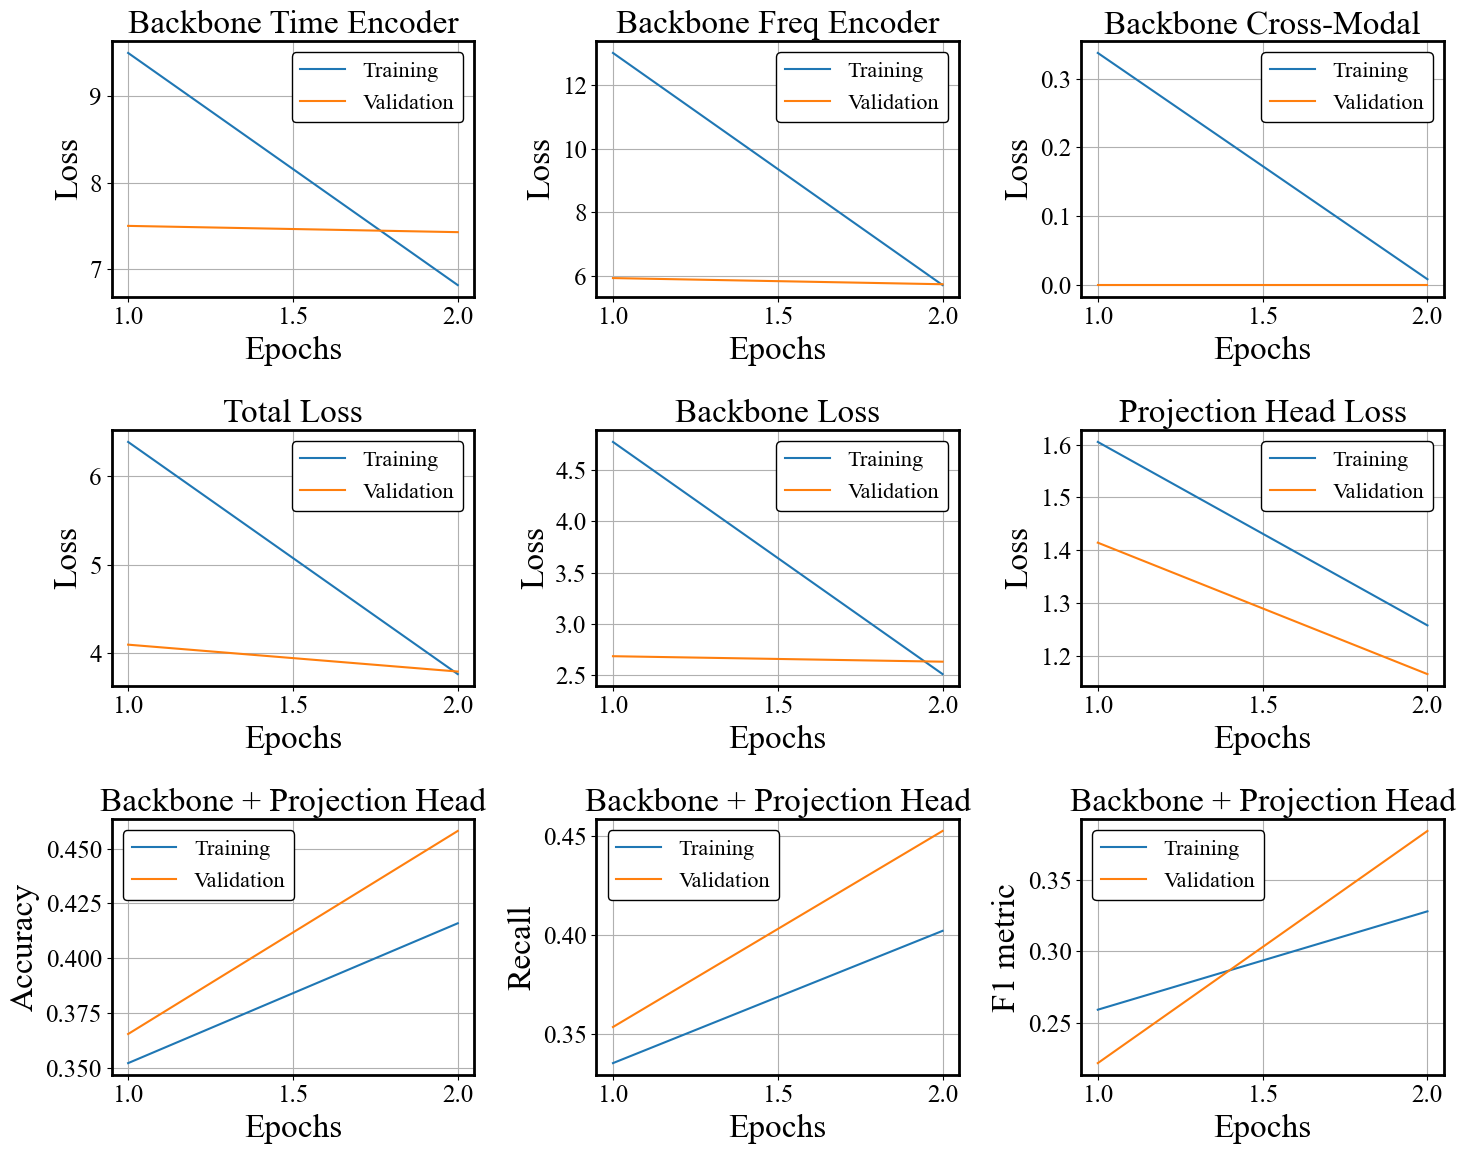

In [26]:
plot_model_metrics(model)

From our classes with the HAR dataset

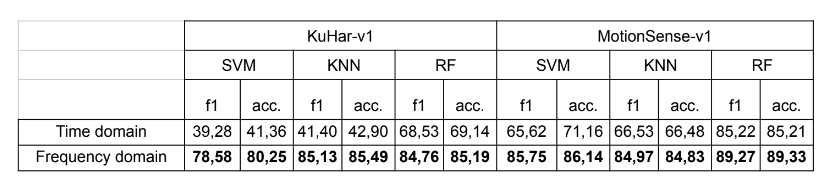

In [27]:
from PIL import Image
from IPython.display import display

pil_image = Image.open('../../images/har_results_reference_table.png')
display(pil_image)

Overall, the score obtained are pretty close the what is seen in the table above, which we are using as a reference

# 4.0 Visualizing the Latent Space

In [37]:
from sklearn.manifold import TSNE

def extract_latent_representations(model, dataloader, device):
    model.eval()
    time_latents = []
    freq_latents = []
    cross_space_latents = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            time_data, time_aug_data, freq_data, freq_aug_data, batch_labels = batch
            time_data, freq_data = time_data.to(device), freq_data.to(device)
            
            time_latents.append(h_time.cpu().numpy())
            freq_latents.append(h_freq.cpu().numpy())
            labels.append(batch_labels.cpu().numpy())
    
    return (np.concatenate(time_latents), 
            np.concatenate(freq_latents), 
            np.concatenate(labels))

def visualize_tsne(time_latents, freq_latents, labels):
    tsne = TSNE(n_components=2, random_state=42)

    print("Fitting TSNE on Time Latents")
    time_tsne = tsne.fit_transform(time_latents)
    print("Fitting TSNE on Freq Latents")
    freq_tsne = tsne.fit_transform(freq_latents)
    print('Fitting Done')
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(time_tsne[:, 0], time_tsne[:, 1], c=labels, cmap='tab10')
    plt.title('Time Encoder Latent Space')
    plt.legend(handles=scatter.legend_elements()[0], labels=list(set(labels)))
    plt.colorbar(scatter)

    plt.subplot(1, 2, 2)
    scatter = plt.scatter(freq_tsne[:, 0], freq_tsne[:, 1], c=labels, cmap='tab10')
    plt.title('Frequency Encoder Latent Space')
    plt.legend(handles=scatter.legend_elements()[0], labels=list(set(labels)))
    plt.colorbar(scatter)


    plt.tight_layout()
    plt.show()


In [38]:
# Configuring the Test Dataloader

batch_size = 128
global_config_file = GlobalConfigFile(batch_size)
pretext_datamodule = build_pretext_datamodule(global_config_file, batch_size=batch_size)
test_dataloader = pretext_datamodule.test_dataloader()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualizing the embedding using t-SNE
time_latents, freq_latents, labels = extract_latent_representations(model, test_dataloader,device=device)
visualize_tsne(time_latents, freq_latents, labels)

Fitting TSNE on Time Latents


KeyboardInterrupt: 

# Old